# BigMart's sales regression

This notebook trains models based on different algorithms in order to make a regression to predict BigMart's sales. This dataset was used for a machine learning competition, so teh test set does not have labels. We will train and evaluate the model  by splitting the original train set.

### Import libraries

In [2]:
from __future__ import absolute_import, division, print_function

import pathlib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statistics import mode

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.1


### Loading data

In [3]:
train_set = pd.read_csv('Data/Train.csv')
test_set = pd.read_csv('Data/Test.csv')

### Data exploration

In [4]:
train_set.shape, test_set.shape

((8523, 12), (5681, 11))

In [5]:
train_set.keys()

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [6]:
train_set.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


We verify here that the test set does not contain the Item_Outlet_Sales which is our target. This is not bad in itself, given that this situation is closer to a real life problem where you do not have the labels of the set you want to predict so the only means to measure the performance of the model is by using the training data and some external knowledge of what the targets should be.

In [7]:
test_set.keys()

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')

In [8]:
test_set.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


The plan is to pre-process and clean both the training set and test set, train and evaluate the model with the training set - splitting it into a train, a validation and a test sets - and then predict the test/target set. So we will merger both to explore and pre-process the data.

In [106]:
train_set['source'] = 'train'
test_set['source'] = 'test'
test_set['Item_Outlet_Sales'] = 0
data = pd.concat([train_set, test_set], sort = False)
print(train_set.shape, test_set.shape, data.shape)

(8523, 13) (5681, 13) (14204, 13)


#### Distribution

In [81]:
train_set['Item_Outlet_Sales'].describe()

count     8523.000000
mean      2181.288914
std       1706.499616
min         33.290000
25%        834.247400
50%       1794.331000
75%       3101.296400
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64

Here we see the train set has positive skewness and a kurtosis smaller than 3 which shows it deviates from a normal distribution.

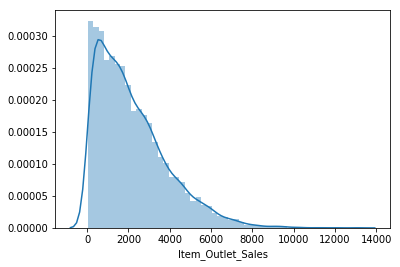

In [82]:
sns.distplot(train_set['Item_Outlet_Sales'])

In [83]:
print('Skewness: %f' % data['Item_Outlet_Sales'].skew())
print('Kurtosis: %f' %data['Item_Outlet_Sales'].kurt())

Skewness: 1.544684
Kurtosis: 2.419439


#### Features exploration

In [84]:
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
source                        object
dtype: object

In [85]:
categorial_features = data.select_dtypes(include=[np.object])
categorial_features.head(2)

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,source
0,FDA15,Low Fat,Dairy,OUT049,Medium,Tier 1,Supermarket Type1,train
1,DRC01,Regular,Soft Drinks,OUT018,Medium,Tier 3,Supermarket Type2,train


In [86]:
for col in categorial_features:
    print('\n%s column: '%col)
    print(data[col].value_counts())


Item_Identifier column: 
FDS59    10
FDN50    10
NCI06    10
DRG48    10
FDR12    10
FDA07    10
FDY52    10
FDP21    10
FDB38    10
FDS21    10
NCR53    10
DRK49    10
FDH21    10
FDA28    10
FDS48    10
FDT04    10
FDQ47    10
FDT51    10
FDA39    10
FDL16    10
NCO18    10
FDZ36    10
FDQ14    10
FDT56    10
FDS15    10
FDG31    10
NCN14    10
NCK31    10
FDC22    10
FDA32    10
         ..
DRJ49     8
FDM01     8
FDJ09     8
FDA45     8
FDU09     8
FDM45     8
FDG52     8
FDE52     8
FDI44     8
NCE18     8
FDA35     8
FDU59     8
NCR50     8
FDA20     8
NCN18     8
FDU19     8
FDT38     8
FDM10     7
FDI46     7
FDX49     7
NCL42     7
FDL50     7
FDH58     7
NCW54     7
FDS22     7
FDO33     7
DRN11     7
FDM52     7
FDM50     7
FDR51     7
Name: Item_Identifier, Length: 1559, dtype: int64

Item_Fat_Content column: 
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Item_Type column: 
Fruits and Vegetables    201

In [87]:
numerical_features = data.select_dtypes(include=[np.number])
numerical_features.head(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
0,9.30,0.016047,249.8092,1999,3735.1380
1,5.92,0.019278,48.2692,2009,443.4228


In [88]:
numerical_stats = numerical_features.describe()
numerical_stats = numerical_stats.transpose()
numerical_stats

,count,mean,std,min,25%,50%,75%,max
Item_Weight,11765.0,12.792854,4.652502,4.555,8.710000,12.600000,16.750000,21.350000
Item_Visibility,14204.0,0.065953,0.051459,0.000,0.027036,0.054021,0.094037,0.328391
Item_MRP,14204.0,141.004977,62.086938,31.290,94.012000,142.247000,185.855600,266.888400
Outlet_Establishment_Year,14204.0,1997.830681,8.371664,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,14204.0,1308.865489,1699.791423,0.000,0.000000,559.272000,2163.184200,13086.964800


In [89]:
data.isna().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
source                          0
dtype: int64

A few remarks about the following two features:

* It is unnatural to have items with visibility zero, given that it is the % of total display area of all products in a store allocated to the particular product. So this would mean, the product was not displayed.


* We can identify that the sales of an item is in a way proportional to its maximum retail price

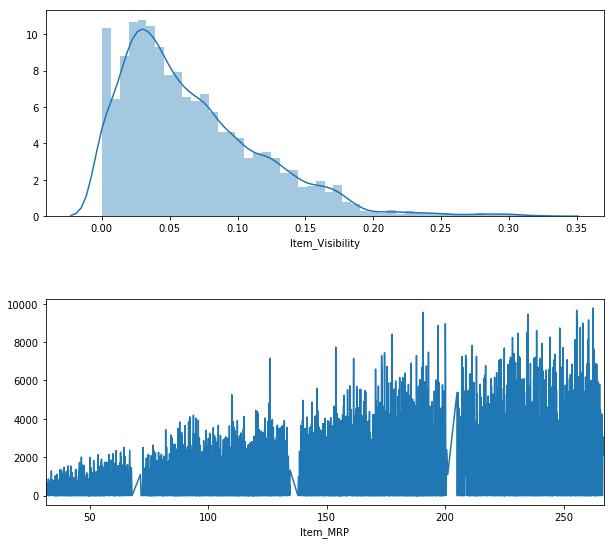

In [127]:
plt.figure(figsize = (10,5))

plt.subplot(211)
sns.distplot(data['Item_Visibility'])

plt.subplot(212)
data.groupby('Item_MRP')['Item_Outlet_Sales'].mean().plot()

plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 1.5)

plt.show()



Here we see that the average sales for stores stablished in 1998 is considerably smaller compared to other years.

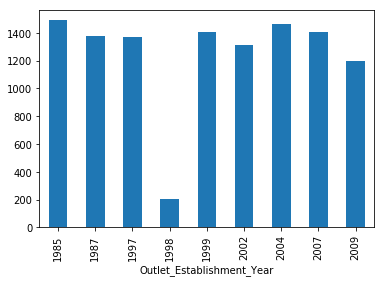

In [98]:
data.groupby('Outlet_Establishment_Year')['Item_Outlet_Sales'].mean().plot.bar()

Finally, we observe here the relation between sales and size, location and outlet type.

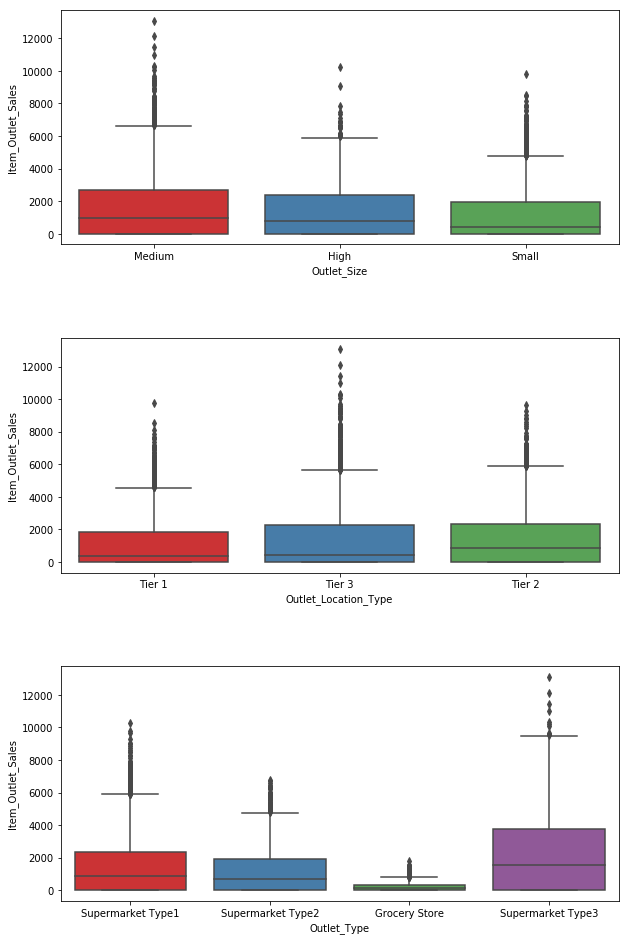

In [124]:
plt.figure(figsize = (10,9))

plt.subplot(311)
sns.boxplot(x='Outlet_Size', y='Item_Outlet_Sales', data=data, palette="Set1")

plt.subplot(312)
sns.boxplot(x='Outlet_Location_Type', y='Item_Outlet_Sales', data=data, palette="Set1")

plt.subplot(313)
sns.boxplot(x='Outlet_Type', y='Item_Outlet_Sales', data=data, palette="Set1")

plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 1.5)

plt.show()

### Cleaning data

For the item weight we will use the average value of each product to fill in missing values which a common used technique for numerical features.

In [103]:
missing_values = data['Item_Weight'].isna()
print('Missing values: %d' %sum(missing_values))

data["Item_Weight"] = data["Item_Weight"].fillna((data["Item_Weight"].mean() ))
print('Missing values after immputation %d' %sum(data['Item_Weight'].isna()))

# item_avg_weight = data.pivot_table(values='Item_Weight', index='Item_Identifier')

# missing_values = data['Item_Weight'].isnull()
# print('Missing values: %d' %sum(missing_values))

# data.loc[missing_values,'Item_Weight']  = data.loc[missing_values,'Item_Identifier'].apply(lambda x: item_avg_weight.at[x,'Item_Weight'])
# print('Missing values after immputation %d' %sum(data['Item_Weight'].isnull()))

Missing values: 2439
Missing values after immputation 0


For the outlet size, since it is determined by the outlet identifier we will use that to fill in the missing ones. Even so, by the end we realize some outlets still do not have a defined size. This will be treated during pre-processing based on the algorithm.

In [74]:
# missing_values = data['Outlet_Size'].isna()
# print('Missing values: %d' %sum(missing_values))

# data["Outlet_Size"] = data["Outlet_Size"].fillna((data["Outlet_Size"].mode()[0] ))
# print('Missing values after immputation %d' %sum(data['Outlet_Size'].isna()))

outlets_sizes = data.pivot_table(values='Outlet_Size', index='Outlet_Identifier', aggfunc=(lambda x : mode(x.astype('str'))))
print(outlets_sizes)

missing_values = data['Outlet_Size'].isna()
print('Missing values: %d' %sum(missing_values))

data.loc[missing_values,'Outlet_Size']  = data.loc[missing_values,'Outlet_Identifier'].apply(lambda x: outlets_sizes.at[x,'Outlet_Size'])
print('Missing values after immputation %d' %sum(data['Outlet_Size'].isnull()))

                  Outlet_Size
Outlet_Identifier            
OUT010                    nan
OUT013                   High
OUT017                    nan
OUT018                 Medium
OUT019                  Small
OUT027                 Medium
OUT035                  Small
OUT045                    nan
OUT046                  Small
OUT049                 Medium
Missing values: 4016
Missing values after immputation 0


The establishement year of the outlets itself is not interesting, but the age of each outlet is.

In [42]:
year_min = data['Outlet_Establishment_Year'].min()
data['Outlet_Age'] = data['Outlet_Establishment_Year'].apply(lambda y : y - year_min)
data.pop('Outlet_Establishment_Year')
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Outlet_Age
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,train,14
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,train,24
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,train,14
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,NaN,Tier 3,Grocery Store,732.3800,train,13
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052,train,2


Another feature we could see had problems in the exploration was the item fat content which had inconsistent values.

In [63]:
#Change categories of low fat:
print('Original Categories:')
print(data['Item_Fat_Content'].value_counts())

print('\nModified Categories:')
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print(data['Item_Fat_Content'].value_counts())

Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


### Building models